In [1]:
from filtros import *
from fit_voc import *

In [4]:
import pandas as pd
import numpy as np
import os

# Ajustamos los parámetros del modelo con una curva de descarga

In [39]:
df = pd.read_csv(os.path.join('data_ejemplos', 'Celdas_stanford', 'C1.csv'))
df = df[df.exp == 0]
df = df[df.step_ind == 14]

df


,step_ind,current,voltage,ch_cap,dis_cap,time,SoH,exp,SoC
17331,14,-0.043655,3.964178,5.833586e-07,0.970025,17317.928608,4.822445,0,0.841985
17332,14,-0.040802,3.964640,5.986852e-07,0.970026,17318.028308,4.822445,0,0.841985
17333,14,-0.037292,3.965101,5.986852e-07,0.970027,17318.129108,4.822445,0,0.841985
17334,14,-0.036438,3.965586,5.986852e-07,0.970027,17318.228308,4.822445,0,0.841985
17335,14,-0.030922,3.965122,5.986852e-07,0.970028,17318.329308,4.822445,0,0.841985
...,...,...,...,...,...,...,...,...,...
205672,14,-1.549683,3.324603,9.138711e-01,4.793695,36152.028208,4.822445,0,0.367973
205673,14,-1.537712,3.325013,9.138711e-01,4.793738,36152.129108,4.822445,0,0.367966
205674,14,-1.543709,3.325568,9.138711e-01,4.793781,36152.228308,4.822445,0,0.367959
205675,14,-1.531418,3.326380,9.138711e-01,4.793824,36152.328508,4.822445,0,0.367952


In [40]:
# Voltaje, corriente y soc
V = df.voltage.values
I = df.current.values
SoC = df.SoC.values

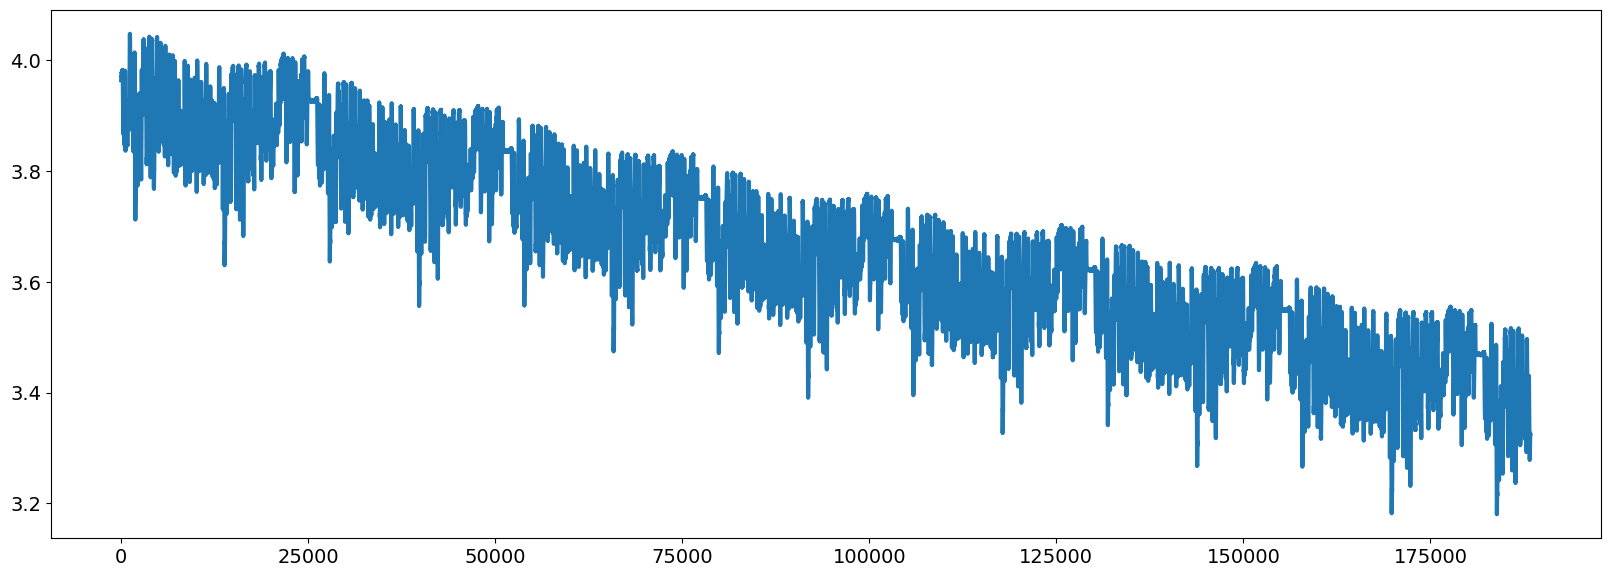

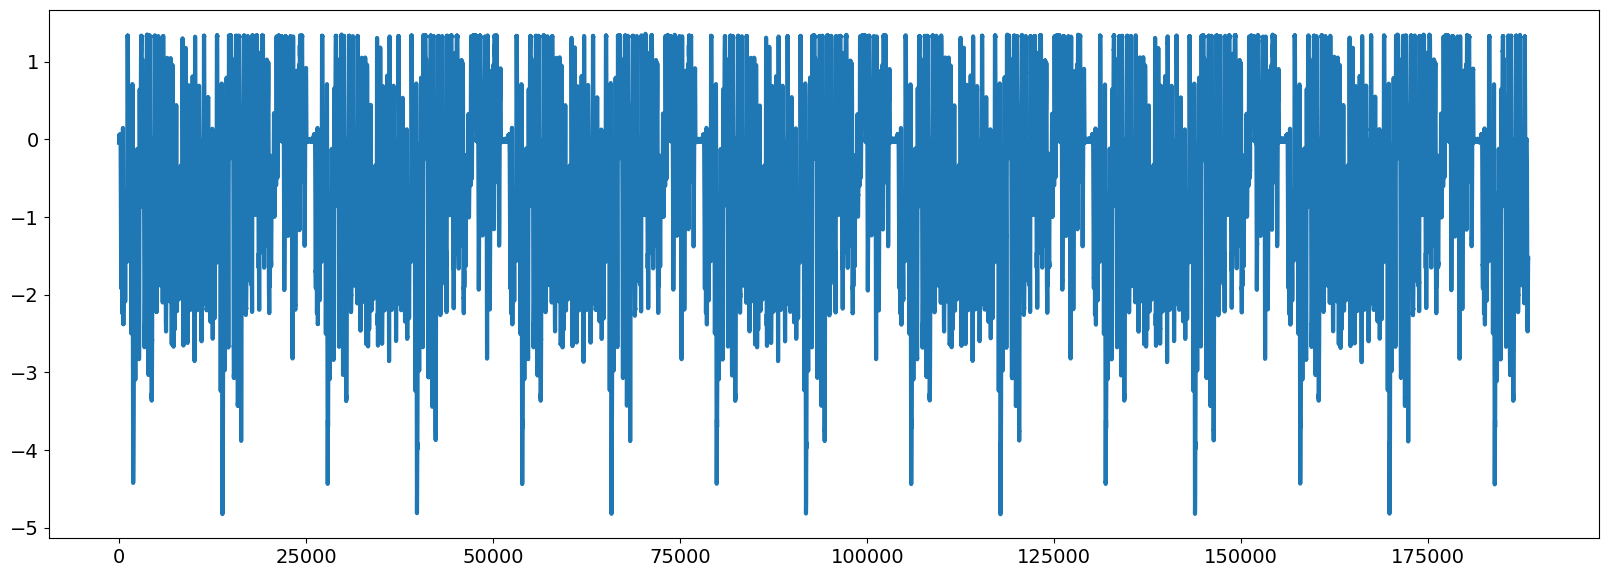

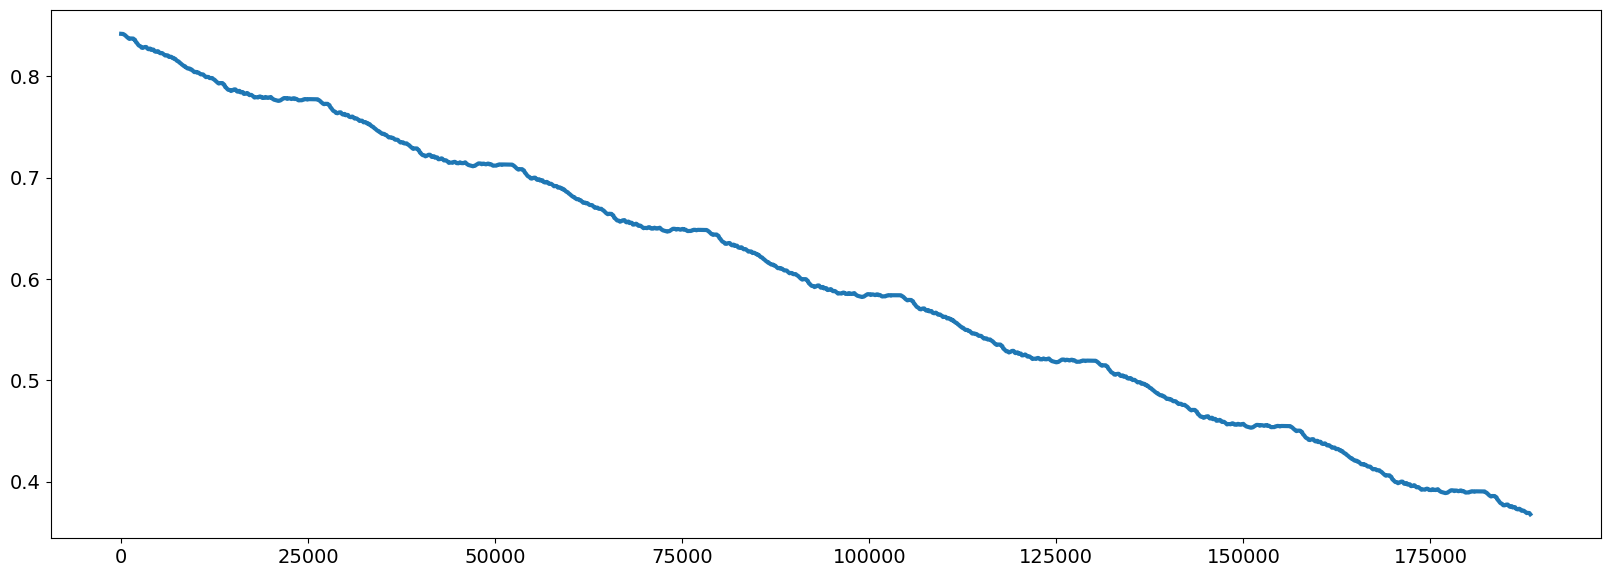

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,7))
plt.plot(V)
plt.show()
plt.figure(figsize=(20,7))
plt.plot(I)
plt.show()
plt.figure(figsize=(20,7))
plt.plot(SoC)
plt.show()

Stopping search: Swarm best objective change less than 1e-08


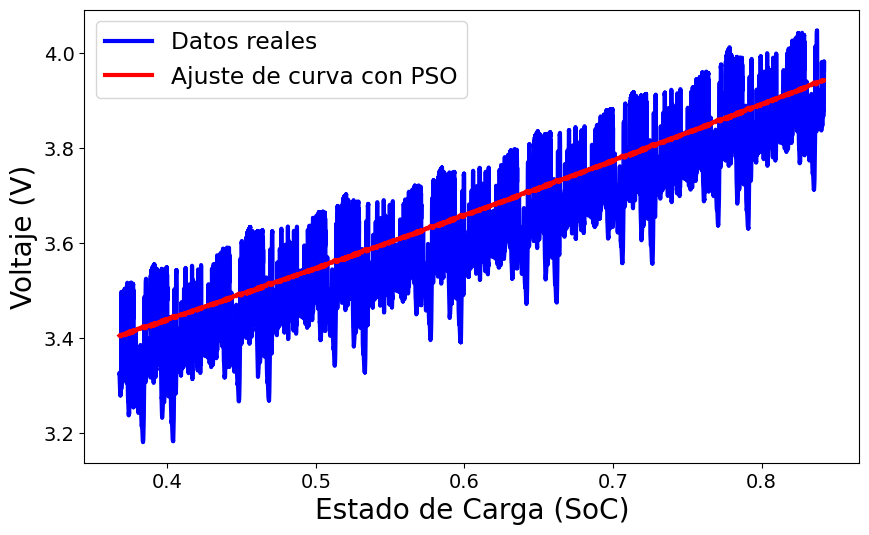

Stopping search: Swarm best objective change less than 1e-08


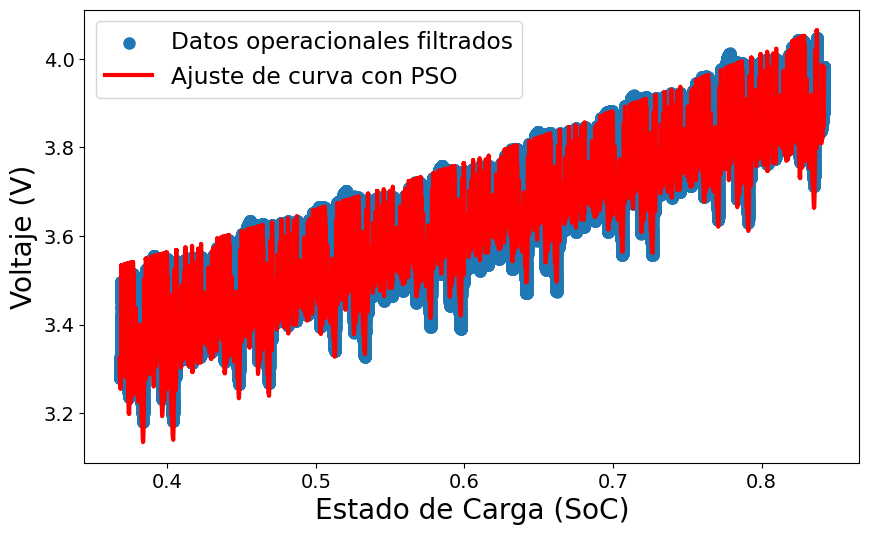

{'Parámetros optimizados': array([1.00000000e-03, 4.13975004e+00, 3.09992254e-01, 2.84732358e-01,
       2.64873085e+00, 1.00000000e-03]), 'Error Cuadrático Medio': 0.004728036150608139}
{'Parámetros optimizados': array([ 7.86716368e-04,  4.17719339e+00,  3.09292404e-01,  3.05089262e-01,
        2.14590581e+00,  9.60246367e-01, -1.64822126e-02]), 'Error Cuadrático Medio': 0.0001769990188645006}


In [42]:
# Generamos los parámetros del modelo mediante la optimización
opts = {'swarmsize': 150, 'maxiter': 150, 'minstep': 1e-8, 'minfunc': 1e-8}

# r:  V_L, V_0, Gamma, Alpha, Beta, R
r = optimizar_con_pso(I, V, SoC)

# r: V_L, V_0, Gamma, Alpha, Beta, factor, bias
r2 = optimizar_con_pso_operacional_esc(I,V,SoC,r['Parámetros optimizados'],0.5,1.5 ,opts  )

print(r)
print(r2)

# Iniciamos el proceso de filtrado

In [48]:
f = FiltrosAnidados()
param = dict(
        vL=r2['Parámetros optimizados'][0],
        v0=r2['Parámetros optimizados'][1],
        gamma=r2['Parámetros optimizados'][2],
        alpha=r2['Parámetros optimizados'][3],
        beta=r2['Parámetros optimizados'][4],
        Factor_Rint=r2['Parámetros optimizados'][5],
        Bias_Rint=r2['Parámetros optimizados'][6],
        Qmax=df.SoH.mean(),
        life_cycles=300,
    )

param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    # Qmax=4.8659,
    Qmax=df.SoH.mean(),
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=300,
)

f.Q_inst = param.get("Qmax")
f.fit_batt_model(param)
f.modelo_th.fit_inverse()


Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.8102965706193315,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0, 1.0, 1.0],
                      '100-25': [1.000003, 1.00000266, 1.00000193],
                      '100-50': [0.999989, 0.99999203, 0.9999942],
                      '100-75': [1.000027, 1.00002146, 1.00001563],
                      '25-0': [1.000054, 1.00004184, 1.00003047],
                      '50-0': [1.000037, 1.00002874, 1.00002093],
                      '50-25': [1.000043, 1.00003347, 1.00002438],
                      '62.5-37.5': [1.000008, 1.0000062, 1.00000451],
                      '75-0': [1.000024, 1.0000186, 1.00001354],
                      '75-25': [1.000019, 1.00001

In [49]:
# Ajustamos los parámetros del estimaodor
f.voc_thresh = 0.05
f.voc_times = 47
f.sigma_autonomia = 0.04
f.sigma_capacidad = 0.001 * 5
f.estim_kwargs = {"sigma_e": 0.00075}


In [50]:
# Iniciamos las configuraciones para el proceso de filtrado
path = os.path.join('data_ejemplos', 'Celdas_stanford')

files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
print(files)

q_healthy = param.get("Qmax")
q_std = 0.0008   * param.get("Qmax")

# Generamos las partículas
N = 50
particulas_soc = np.random.uniform(0.2, 1, N)
pesos_soc = np.ones(N) / N

particulas_q = np.random.uniform(4.7, 4.9, N)
pesos_q = np.ones(N) / N

# Valor se SoC acumulado. Nos dirá cuándo se cumple un ciclo equivalente
soc_acc = 0
soc_filt = []


points_f = []
estimaciones_q = []
factores_q = []

['C1.csv', 'C2.csv']


In [51]:
# Iteramos por todos los datasets
for file in files:
    if not ".csv" in file:
        continue
    cycle = file[: file.find(".")]


    cap_list = []  # dataset, estimador, modelo, filtro
    part_filt_list = []  # partícula, pesos
    intresting_points_list = []  # puntos interesantes

    df = pd.read_csv(os.path.join(path, file))

    # iteramos por cada experimento obteniendo estimaciones
    for cnt, exp in enumerate(df.exp.unique()):
        # if cnt % 5:continue
        print("\n", file, cnt)

        df_ = df[df.exp == exp]

        # probamos filtrar el soc y las estimaciones de forma simultánea, solo consideramos datos cunado el experimento es 14
        for ind, (c, c_, v, dt, step) in enumerate(zip(
                                                        df_.current.values[1:],
                                                        df_.current.values,
                                                        df_.voltage.values[1:],
                                                        df_.time.values[1:] - df_.time.values[:-1],
                                                        df_.step_ind.values[1:],
                                                    )):

            # Filtramos el SoC
            particulas_soc, pesos_soc, soc_ponderado, v_part = f.filtrar_soc(
                particulas_soc, pesos_soc, v, c, c_, dt
            )
            sumando = dt * abs(c) / (f.Q_inst * 3600) if c < 0 else 0
            soc_acc += sumando  # variable que usamos para verificar cuándo se cumple el ciclo equivalente

            soc_filt.append(soc_ponderado)
            print(f"{step}\t{soc_acc:.3f}", end="\r")

            # Colectamos puntos del voltaje en circuito abierto cunando sea necesario
            if step == 14:  # Si estamos en puntos con descarga realista

                _ = f.detect_iterest_points(v, c, dt, False)


            if 1 <= soc_acc:
                if len(factores_q) != 0:

                    # Estimamos con ML con los datos
                    # q_estim = f.estimate_ML((3,5), log=True)
                    # q_estim = f.estimate_ML(np.clip([f.Q_inst-4.8659*0.01,f.Q_inst+4.8659*0.01],3,4.8659), log=True)
                    # estimaciones_q = np.array(estimaciones_q)
                    # factores_q = np.array(factores_q)

                    # q_estim = np.sum(factores_q / sum(factores_q) * estimaciones_q)
                    q_estim = estimaciones_q[np.argmax(factores_q)]
                    q_estim_ = np.clip(q_estim, 0, q_healthy)

                    # Obtenemos las predicciones del modelo

                    factor = f.get_factor(soc_filt)

                    # Obtenemos el modelo filtrado
                    particulas_q, pesos_q, capacidad_ponderada = f.filtrar_q(
                        particulas_q, pesos_q, soc_filt, q_estim_, q_std
                    )

                    cap_list.append(
                        [
                            df_.SoH.mean(),
                            q_estim_,
                            q_estim,
                            f.Q_inst * factor,
                            capacidad_ponderada,
                        ]
                    )
                    part_filt_list.append([particulas_q, pesos_q])
                    intresting_points_list.append(points_f)

                    # print('\n',f.detected_points.shape, f.Q_inst, q_estim,capacidad_ponderada,df_.SoH.mean() )
                    print(factores_q)
                    print(estimaciones_q)
                    print(
                        q_estim / q_healthy * 100,
                        abs(q_estim_) / q_healthy * 100,
                        (capacidad_ponderada) / q_healthy * 100,
                        df_.SoH.mean() / q_healthy * 100,
                    )
                    print(
                        abs(q_estim - df_.SoH.mean()) / q_healthy * 100,
                        abs(q_estim_ - df_.SoH.mean()) / q_healthy * 100,
                        abs(capacidad_ponderada - df_.SoH.mean()) / q_healthy * 100,
                        "\n",
                    )

                    # Reseteamos las variables de memoria en el estimador
                    # f.reset_detector([1, 1])
                    soc_filt = []
                    estimaciones_q = []
                    factores_q = []
                    soc_acc = 0

                    # Ajustamos la capacidad instantánea
                    f.Q_inst = capacidad_ponderada
                else:
                    print(factores_q)
                    soc_acc = 0

                    print("No se encontraron puntos para estimar")
                    cap_list.append(
                        [
                            df_.SoH.mean(),
                            np.NaN,
                            np.NaN,
                            np.NaN,
                            np.NaN,
                        ]
                    )
                    part_filt_list.append([particulas_q, pesos_q])
                    intresting_points_list.append(points_f)

        # Reseteamos las variables de memoria en el estimador
        if not f.detected_points is None:
            estimaciones_q.append(f.estimate_ML((3, 7), log=True))
            factores_q.append(len(f.detected_points))
            points_f.append(f.detected_points)

        f.reset_detector([1, 1])


 C1.csv 0
14	0.997
 C1.csv 1
[185]000
[4.942358383908868]
102.74539857056118 100.0 100.03417183507312 100.23179661879989
2.5136019517612938 0.2317966187998817 0.19762478372675382 

14	0.993
 C1.csv 2
[184]000
[4.931188735179603]
102.51319565821919 100.0 99.97805379725109 100.21104422256202
2.302151435657176 0.21104422256201394 0.23299042531091047 

14	0.990
 C1.csv 3
[185]000
[4.927796445786953]
102.44267423936593 100.0 99.97014437791513 100.19029182632401
2.25238241304192 0.19029182632401698 0.220147448408894 

14	0.987
 C1.csv 4
[184]000
[4.9168040081858635]
102.21415532291846 100.0 99.9260476352265 100.1695394300863
2.0446158928321436 0.16953943008631542 0.2434917948598136 

14	0.984
 C1.csv 5
[188]000
[4.919064799323678]
102.26115431985396 100.0 99.9421345215003 100.14878703384842
2.1123672860055627 0.14878703384841077 0.20665251234812232 

14	0.981
 C1.csv 6
[180]000
[4.908050200901926]
102.03217470788934 100.0 99.94570117454937 100.12803463761047
1.9041400702788658 0.12803463761